## Amazon Fine Food Reviews

Dataset: [via Kaggle](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data) 

This dataset consists of reviews of fine foods from amazon.   
The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.   
Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.  

## <b>1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from tqdm.notebook import tqdm
from pprint import pprint

#Specify type of visualization
plt.style.use('ggplot')

## <b>2. Read data

But before we getting things started, i want to introduce the data dictionary of the dataset.  
According to Kaggle:  
- Id: Row Id  
- ProductId: Unique identifier for the product  
- UserId: Unqiue identifier for the user  
- ProfileName: Profile name of the user  
- HelpfulnessNumerator: Number of users who found the review helpful  
- HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not  
- Score: Rating between 1 and 5  
- Time: Timestamp for the review  
- Summary: Brief summary of the review  
- Text: Text of the review  

In [2]:
df = pd.read_csv('Reviews.csv')
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
print('Rows:', df.shape[0])
print('Columns:', df.shape[1])

Rows: 568454
Columns: 10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### <b>3. Clean (if needed)

In [5]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
df.duplicated().sum()

0

The above results are acceptable cuz' I won't use those column 😉

## <b>4. EDA

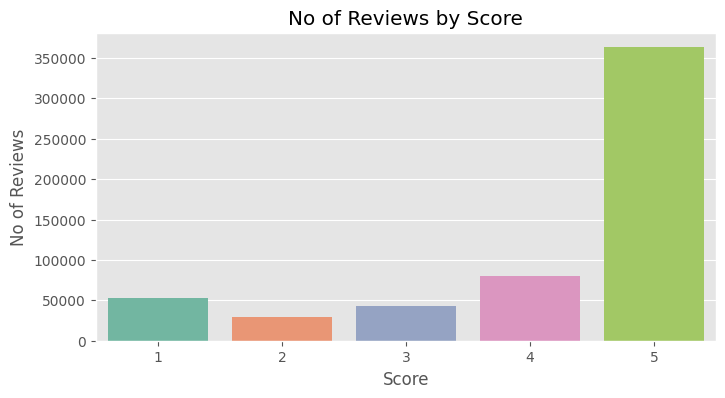

In [7]:
score_grp = df.groupby(by = 'Score').agg(count = ('Score','count')).reset_index()


plt.figure(figsize=(8,4))
ax = sns.barplot(data = score_grp
                ,x = 'Score'
                ,y = 'count'
                ,palette='Set2')
ax.set_xlabel('Score')
ax.set_ylabel('No of Reviews')
ax.set_title('No of Reviews by Score')

plt.show()

### <b>5. Setups for NLTK

In [8]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-

True

In [9]:
stop_words = set(stopwords.words('english'))

<b>Cuz I ran the polarity_score calculation for some random 'Text'  
The score are affected by stopwords, so I decided to remove them

In [10]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [11]:
df.columns = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'RawText']

In [12]:
df['Text'] = df['RawText'].apply(remove_stopwords)

<b>I will use a test case to see how it works. I pick the entry along with the index 312.

In [13]:
test = df['Text'][31201]
test

'first, impressed round little cracker/chip things. novelty wears fast. decided quite gross.'

<b>Steps: 
1. Lets tokenize it: word_tokenize()
2. Get a tag for each items in the tokens list. Then, represent them as a list of tuple ('word', 'type of word - written in an abbreviation'): pos_tag
3. Visualize list of entities in the tag: ne_chunk()

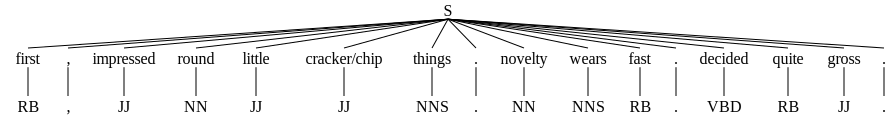

In [14]:
tokens = nltk.word_tokenize(test)
tags = nltk.pos_tag(tokens)
entities = nltk.ne_chunk(tags)
entities

In [15]:
pprint(entities)

Tree('S', [('first', 'RB'), (',', ','), ('impressed', 'JJ'), ('round', 'NN'), ('little', 'JJ'), ('cracker/chip', 'JJ'), ('things', 'NNS'), ('.', '.'), ('novelty', 'NN'), ('wears', 'NNS'), ('fast', 'RB'), ('.', '.'), ('decided', 'VBD'), ('quite', 'RB'), ('gross', 'JJ'), ('.', '.')])


### <b>6. VADER Sentiment

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
pol_list = []

for text in tqdm(df['Text']):
    pol =  sia.polarity_scores(text)
    pol_list.append(pol)

  0%|          | 0/568454 [00:00<?, ?it/s]

<b>☝ Welp, nearly 570k entries takes about 10 mins to complete the loops    
Pretty slow T.T I think I should run for a smaller sample.

In [18]:
df_pol_score = pd.DataFrame(pol_list)
df_pol_score['Id'] = df['Id']
df_pol_score['Score'] = df['Score']
df_pol_score['Text'] = df['Text']
df_pol_score.head()

,neg,neu,pos,compound,Id,Score,Text
0,0.000,0.517,0.483,0.9413,1,5,bought several Vitality canned dog food produc...
1,0.129,0.762,0.110,-0.1027,2,1,Product arrived labeled Jumbo Salted Peanuts.....
2,0.165,0.560,0.275,0.8073,3,4,"confection around centuries. light, pillowy ci..."
3,0.000,1.000,0.000,0.0000,4,2,looking secret ingredient Robitussin believe f...
4,0.000,0.369,0.631,0.9468,5,5,Great taffy great price. wide assortment yummy...


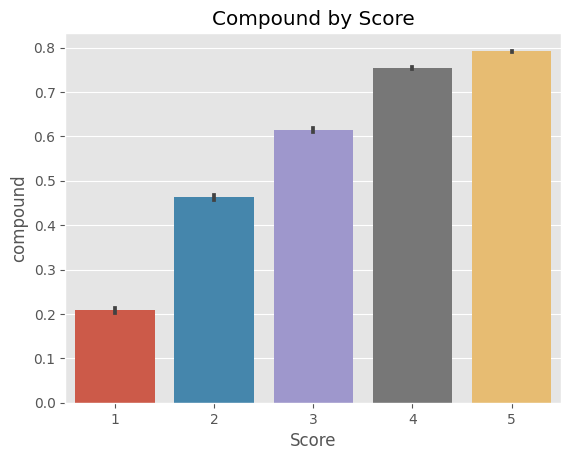

In [19]:
ax = sns.barplot(data = df_pol_score
            ,x = 'Score'
            ,y = 'compound')
ax.set_title('Compound by Score')
plt.show()

<b>👉 I suppose that the higher rating score corresponds to a higher compound value.   
Last but not least, I want to check if there is any differentiation in the reviews for each value of 'Score'.

  0%|          | 0/3 [00:00<?, ?it/s]

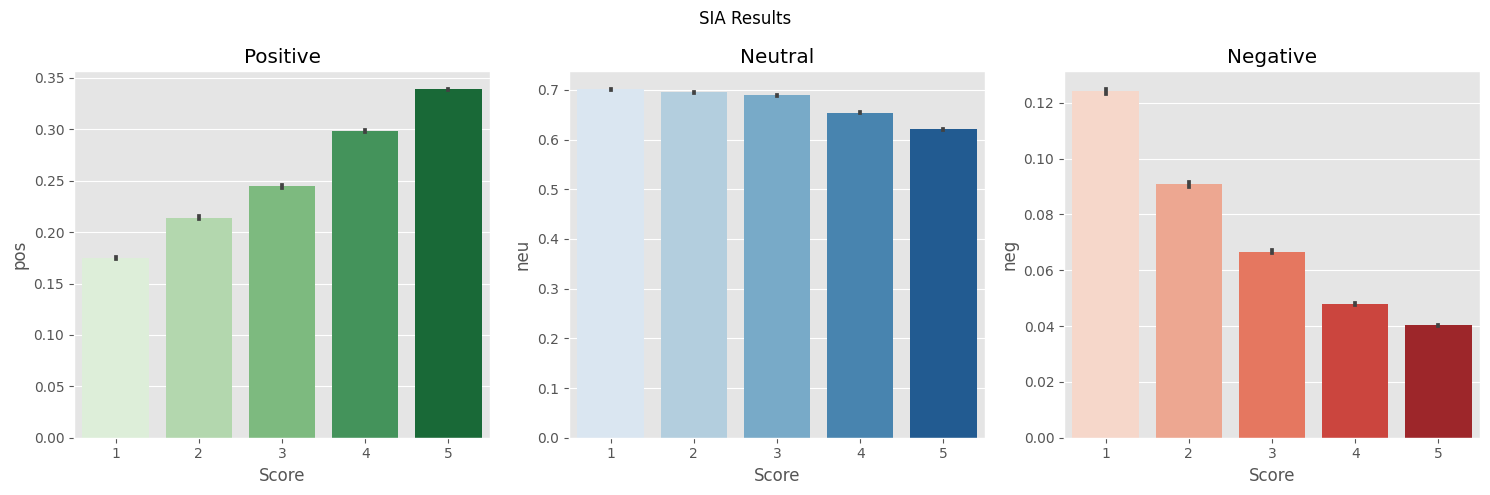

In [20]:
fig, axes = plt.subplots(1,3,figsize = (15,5))

pol_types = ['pos','neu','neg']
pol_names = ['Positive','Neutral','Negative']
color = ['Greens','Blues','Reds']

n = 0

for pol_type in tqdm(pol_types):  
    sns.barplot(data = df_pol_score
                ,x = 'Score'
                ,y = pol_type
                ,ax = axes[n]
                ,palette=color[n])
    axes[n].set_title(pol_names[n])
    n+=1

plt.suptitle('SIA Results')

plt.tight_layout()
plt.show()

<b>👉 To conclude, VADER gave me results as belows:
1. For Positive polarity score, the highest value comes to Score = 5.
2. For Neutral polarity score, the values tend to be relatively consistent.
3. For Negative polarity score, the lowest value comes to Score = 1.

### <b>7. More EDA after merging VADER into the root dataframe

In [21]:
df_merge_vader = df.merge(df_pol_score, how = 'inner')
df_merge_vader.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,RawText,Text,neg,neu,pos,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...,0.000,0.517,0.483,0.9413
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanuts.....,0.129,0.762,0.110,-0.1027


In [22]:
df_merge_vader.loc[df_merge_vader['compound'] >= 0.5, 'VaderSegment'] = 'Positive'
df_merge_vader.loc[df_merge_vader['compound'] <= -0.5, 'VaderSegment'] = 'Negative'
df_merge_vader.loc[(df_merge_vader['compound'] < 0.5) & (df_merge_vader['compound'] > -0.5), 'VaderSegment'] = 'Neutral'

In [23]:
df_merge_vader['Date']  = df_merge_vader['Time'].apply(lambda x: datetime.fromtimestamp(x))
df_merge_vader['Month'] = df_merge_vader['Date'].dt.month 
df_merge_vader['Year']  = df_merge_vader['Date'].dt.year
df_merge_vader.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,RawText,Text,neg,neu,pos,compound,VaderSegment,Date,Month,Year
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several Vitality canned dog food produc...,0.000,0.517,0.483,0.9413,Positive,2011-04-27 07:00:00,4,2011
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanuts.....,0.129,0.762,0.110,-0.1027,Neutral,2012-09-07 07:00:00,9,2012


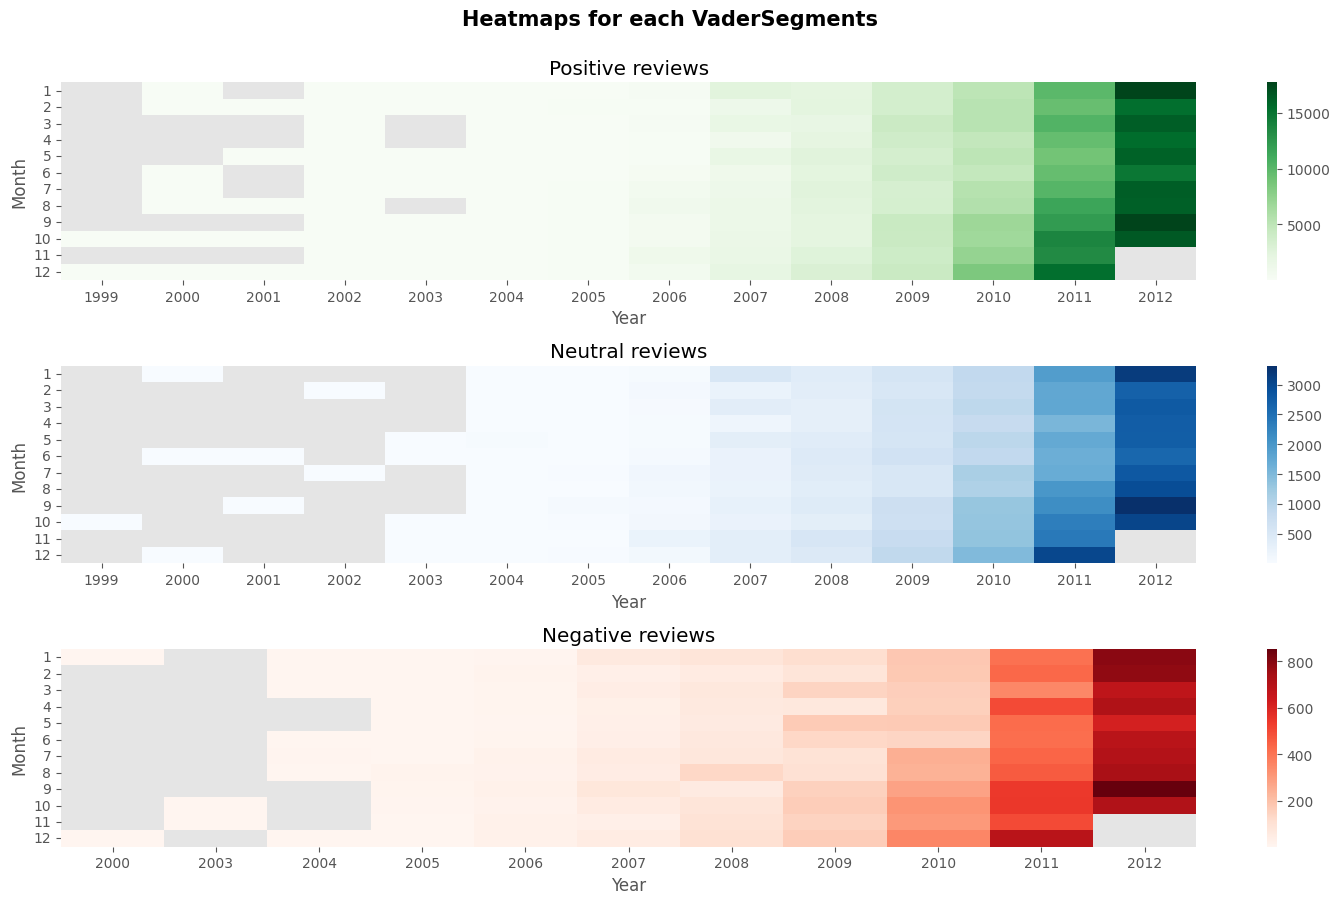

In [24]:
fig, axes = plt.subplots(3,1,figsize = (15,9))

plt.suptitle('Heatmaps for each VaderSegments'
             , x = 0.45
             , y = 1
             , fontsize = 15
             , fontweight = 'bold')

segment_list = ['Positive','Neutral','Negative']
cmap_list = ['Greens','Blues','Reds']
name_list = ['Positive reviews','Neutral reviews','Negative reviews']

n = 0 

for df_seg in segment_list: 
    df_vader_piv = df_merge_vader[df_merge_vader['VaderSegment'] == segment_list[n]]\
                .pivot_table(values = 'Id'
                            ,index = 'Month'
                            ,columns='Year'
                            ,aggfunc='count')


    sns.heatmap(df_vader_piv
                ,cmap= cmap_list[n]
                ,ax = axes[n])

    axes[n].set_xticklabels(axes[n].get_xticklabels(), rotation=0)
    axes[n].set_yticklabels(axes[n].get_yticklabels(), rotation=0)
    axes[n].set_title(name_list[n])

    n+=1

plt.tight_layout()
plt.show()

<b>👉 For the most part, reviews exploded in the year 2010 to 2012.

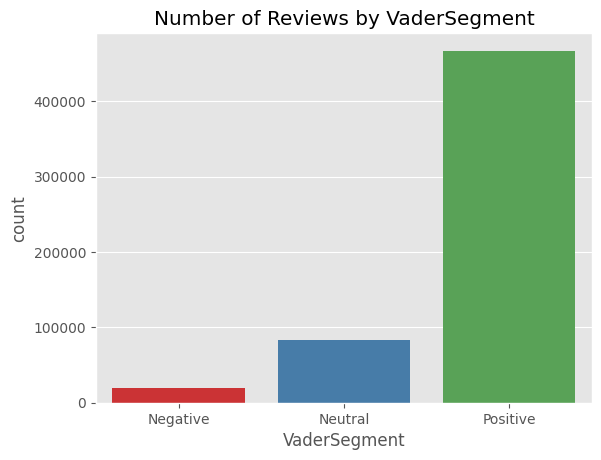

In [25]:
df_vader_count = df_merge_vader.groupby(by = 'VaderSegment').agg(count = ('Id','count')).reset_index()
sns.barplot(data = df_vader_count
            ,x = 'VaderSegment'
            ,y = 'count'
            ,palette='Set1')
plt.title('Number of Reviews by VaderSegment')
plt.show()

<b>👉 The plot showed that most of the reviews over the given time periods brought postive vibes.

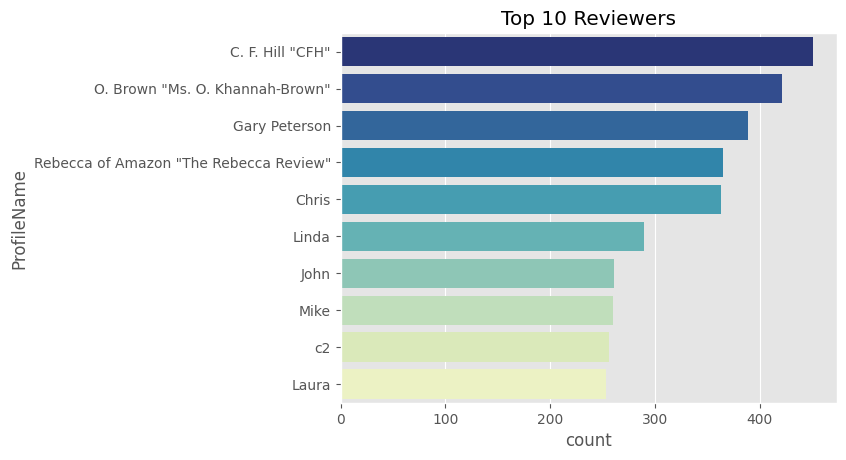

In [26]:
top_contributor = df_merge_vader\
            .groupby(by = 'ProfileName').agg(count = ('Id','count'))\
            .reset_index() \
            .sort_values(by = 'count',ascending=False).head(10)

sns.barplot(data = top_contributor
            ,x = 'count'
            ,y = 'ProfileName'
            ,palette='YlGnBu_r')
plt.title('Top 10 Reviewers')
plt.show()

<b>👉 They are top 10 reviewers who wrote the most number of reviews on the platform.  
I think Amazon should honor them with "The reward for the highest valuable customers"

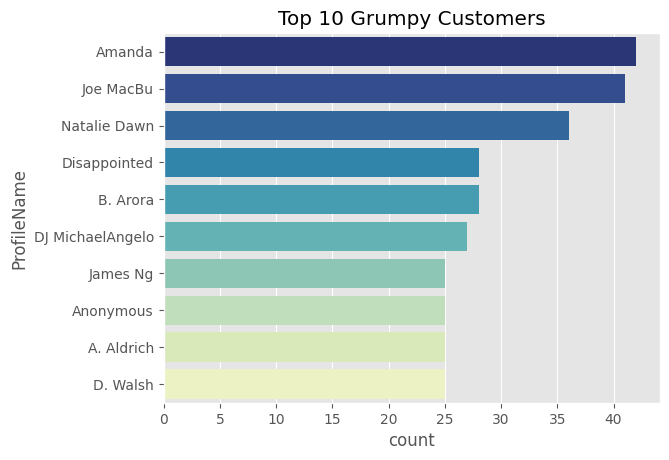

In [27]:
grumpy_customer = df_merge_vader[df_merge_vader['VaderSegment'] == 'Negative']\
            .groupby(by = 'ProfileName').agg(count = ('Id','count'))\
            .reset_index() \
            .sort_values(by = 'count',ascending=False).head(10)

sns.barplot(data = grumpy_customer
            ,x = 'count'
            ,y = 'ProfileName'
            ,palette='YlGnBu_r')
plt.title('Top 10 Grumpy Customers')
plt.show()

<b>👉 They are top 10 grumpy customers who wrote the most number of negative reviews on the platform.  
CX's Amazon team should take care of them and ask the customer for more details about the issue.   
Gathering additional information can help the platform better understand the problem and how to fix it.

In [28]:
vader_type = ['Positive', 'Neutral', 'Negative']
cmap_list = ['Greens', 'Blues', 'Reds']

fig, axes = plt.subplots(3, 1, figsize=(8, 10))

for n, sentiment in enumerate(vader_type):
    text = " ".join(review.strip() for review in df_merge_vader[df_merge_vader['VaderSegment'] == sentiment]['Text']\
                    .str.replace('br',' ')\
                    .str.replace('Br',' ')\
                    )
    
    wc = WordCloud(width=600, height=200, background_color='white', colormap=cmap_list[n]).generate(text)

    axes[n].imshow(wc, interpolation='bilinear')
    axes[n].set_title(f'Most Frequent Keywords in {sentiment} Reviews')
    axes[n].axis('off')

plt.suptitle('WordClouds for Different Sentiments', fontsize=16)
plt.tight_layout()
plt.show()

<b>👉These Wordclouds showed the most frequently occurring words in each type of review 

## The End 🤗